# XGBoost Forecasting Model for Shrimp Farm

## Objective
This notebook demonstrates how to build a forecasting model using XGBoost to predict future shrimp growth (average weight) based on historical farm data.

## What We'll Learn
1. Loading and exploring time series data
2. Feature engineering for time series forecasting
3. Training an XGBoost regression model
4. Making predictions and evaluating performance
5. Visualizing results


## Step 1: Import Required Libraries


In [8]:
import pandas as pd
import numpy as np
import json
import glob
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


## Step 2: Load Historical Data

We'll load multiple JSON files containing historical farm data snapshots.


In [ ]:
# Find all farm data JSON files (both old and new formats)
data_files = glob.glob('farm_data_*.json') + glob.glob('forecasting_training_data_*.json')
print(f"Found {len(data_files)} data files")

# Load all data files
all_data = []
for file in sorted(data_files):
    with open(file, 'r') as f:
        data = json.load(f)
        # Handle both formats:
        # - Old format: single snapshot object
        # - New format: array of snapshots
        if isinstance(data, list):
            # New format: array of snapshots
            all_data.extend(data)
        else:
            # Old format: single snapshot
            all_data.append(data)

print(f"Loaded {len(all_data)} data snapshots")


Found 202 data files
Loaded 20002 data snapshots


## Step 3: Convert Data to Time Series Format

We need to extract the feed data (which contains shrimp weight) and organize it by time and pond.


In [10]:
# Extract feed data with timestamps
time_series_data = []

for snapshot in all_data:
    timestamp = datetime.fromisoformat(snapshot['timestamp'])
    
    # Extract feed data for each pond
    for feed_entry in snapshot.get('feed', []):
        pond_id = feed_entry['pond_id']
        avg_weight = feed_entry['average_weight']
        shrimp_count = feed_entry['shrimp_count']
        feed_amount = feed_entry['feed_amount']
        
        # Get corresponding water quality data
        wq_data = next((wq for wq in snapshot.get('water_quality', []) 
                       if wq['pond_id'] == pond_id), None)
        
        if wq_data:
            time_series_data.append({
                'timestamp': timestamp,
                'pond_id': pond_id,
                'avg_weight': avg_weight,
                'shrimp_count': shrimp_count,
                'feed_amount': feed_amount,
                'ph': wq_data.get('ph', 7.5),
                'temperature': wq_data.get('temperature', 28),
                'dissolved_oxygen': wq_data.get('dissolved_oxygen', 6.0),
                'salinity': wq_data.get('salinity', 20),
                'ammonia': wq_data.get('ammonia', 0.1)
            })

# Convert to DataFrame
df = pd.DataFrame(time_series_data)
df = df.sort_values(['pond_id', 'timestamp']).reset_index(drop=True)

print(f"Total records: {len(df)}")
print(f"Date range: {df['timestamp'].min()} to {df['timestamp'].max()}")
print(f"Number of ponds: {df['pond_id'].nunique()}")
print("\nFirst few rows:")
df.head(10)


Total records: 20008
Date range: 2024-01-13 00:00:00 to 2037-11-28 00:00:00
Number of ponds: 4

First few rows:


,timestamp,pond_id,avg_weight,shrimp_count,feed_amount,ph,temperature,dissolved_oxygen,salinity,ammonia
0,2024-03-22,1,0.80,11037,101.19,7.52,27.8,6.5,18.8,0.072
1,2024-03-23,1,0.94,11037,171.76,7.54,27.4,7.6,20.1,0.042
2,2024-03-24,1,1.08,11037,149.08,7.88,27.7,5.8,19.6,0.029
3,2024-03-25,1,1.20,11037,202.82,7.61,27.7,6.6,19.8,0.058
4,2024-03-26,1,1.32,11037,180.67,7.75,27.4,7.5,21.3,0.071
5,2024-03-27,1,1.45,11037,172.82,7.54,27.4,7.1,21.1,0.089
6,2024-03-28,1,1.56,11037,242.56,7.74,27.8,7.6,22.2,0.104
7,2024-03-29,1,1.65,11037,281.68,7.77,28.0,5.8,20.2,0.134
8,2024-03-30,1,1.76,11037,260.91,7.99,27.7,6.5,19.6,0.155
9,2024-03-31,1,1.88,11037,230.38,7.49,28.1,7.0,18.9,0.083


## Step 4: Explore the Data

Let's visualize the data to understand trends and patterns.


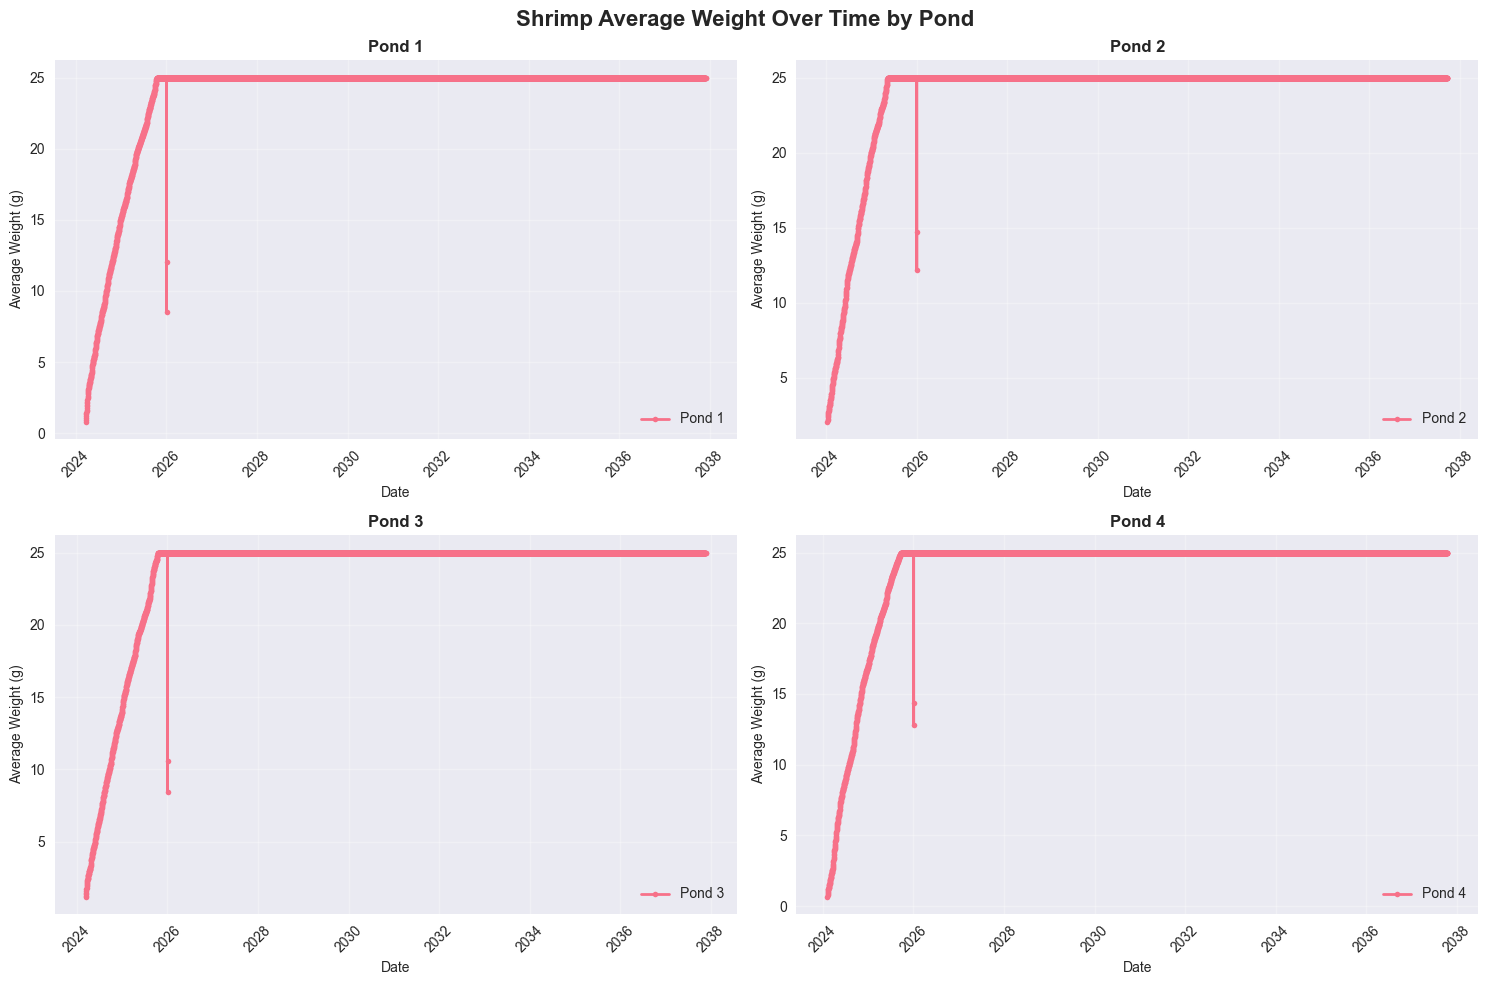


Summary Statistics:
         avg_weight   temperature  dissolved_oxygen            ph  \
count  20008.000000  20008.000000      20008.000000  20008.000000   
mean      23.801949     28.064927          6.141490      8.019730   
std        4.049645      1.498585          0.826761      0.391998   
min        0.660000     24.900000          4.000000      7.200000   
25%       25.000000     26.700000          5.575000      7.680000   
50%       25.000000     28.100000          6.100000      8.030000   
75%       25.000000     29.400000          6.700000      8.360000   
max       25.000000     30.900000          8.200000      8.810000   

        feed_amount  
count  20008.000000  
mean    1896.383789  
std      841.626178  
min       41.560000  
25%     1358.872500  
50%     1719.910000  
75%     2274.012500  
max     6664.240000  


In [ ]:
# Plot average weight over time for each pond
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Shrimp Average Weight Over Time by Pond', fontsize=16, fontweight='bold')

for idx, pond_id in enumerate(sorted(df['pond_id'].unique())[:4]):
    ax = axes[idx // 2, idx % 2]
    pond_data = df[df['pond_id'] == pond_id]
    
    ax.plot(pond_data['timestamp'], pond_data[''], 
            marker='o', linewidth=2, markersize=4, label=f'Pond {pond_id}')
    ax.set_xlabel('Date', fontsize=10)
    ax.set_ylabel('Average Weight (g)', fontsize=10)
    ax.set_title(f'Pond {pond_id}', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend()
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

plt.tight_layout()
plt.show()

# Summary statistics
print("\nSummary Statistics:")
print(df[['avg_weight', 'temperature', 'dissolved_oxygen', 'ph', 'feed_amount']].describe())


## Step 5: Feature Engineering for Time Series Forecasting

For time series forecasting, we need to create features that capture:
- **Lag features**: Previous values of the target variable
- **Rolling statistics**: Moving averages, standard deviations
- **Time features**: Day of week, days since start, etc.
- **Other features**: Water quality parameters, feed amounts


In [12]:
def create_features(df, target_col='avg_weight', lags=[1, 2, 3, 7], window_sizes=[3, 7, 14]):
    """
    Create time series features for forecasting
    
    Parameters:
    - df: DataFrame with time series data
    - target_col: Column name to forecast
    - lags: List of lag periods to create
    - window_sizes: List of window sizes for rolling statistics
    """
    df = df.copy()
    df = df.sort_values(['pond_id', 'timestamp']).reset_index(drop=True)
    
    # Create time-based features
    df['day_of_week'] = df['timestamp'].dt.dayofweek
    df['day_of_month'] = df['timestamp'].dt.day
    df['month'] = df['timestamp'].dt.month
    
    # Calculate days since first record for each pond
    df['days_since_start'] = df.groupby('pond_id')['timestamp'].transform(
        lambda x: (x - x.min()).dt.days
    )
    
    # Create lag features (previous values)
    for lag in lags:
        df[f'{target_col}_lag_{lag}'] = df.groupby('pond_id')[target_col].shift(lag)
    
    # Create rolling statistics (moving averages, std dev)
    for window in window_sizes:
        df[f'{target_col}_rolling_mean_{window}'] = df.groupby('pond_id')[target_col].transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=1).mean()
        )
        df[f'{target_col}_rolling_std_{window}'] = df.groupby('pond_id')[target_col].transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=1).std()
        )
    
    # Create growth rate features
    df['weight_change'] = df.groupby('pond_id')[target_col].diff(1)
    df['weight_change_pct'] = df.groupby('pond_id')[target_col].pct_change(1)
    
    # Rolling statistics for other important features
    for col in ['temperature', 'dissolved_oxygen', 'ph', 'feed_amount']:
        df[f'{col}_rolling_mean_7'] = df.groupby('pond_id')[col].transform(
            lambda x: x.shift(1).rolling(window=7, min_periods=1).mean()
        )
    
    return df

# Apply feature engineering
df_features = create_features(df)

print("Feature engineering completed!")
print(f"Original columns: {len(df.columns)}")
print(f"Features after engineering: {len(df_features.columns)}")
print("\nNew features created:")
new_features = [col for col in df_features.columns if col not in df.columns]
print(new_features)


Feature engineering completed!
Original columns: 10
Features after engineering: 30

New features created:
['day_of_week', 'day_of_month', 'month', 'days_since_start', 'avg_weight_lag_1', 'avg_weight_lag_2', 'avg_weight_lag_3', 'avg_weight_lag_7', 'avg_weight_rolling_mean_3', 'avg_weight_rolling_std_3', 'avg_weight_rolling_mean_7', 'avg_weight_rolling_std_7', 'avg_weight_rolling_mean_14', 'avg_weight_rolling_std_14', 'weight_change', 'weight_change_pct', 'temperature_rolling_mean_7', 'dissolved_oxygen_rolling_mean_7', 'ph_rolling_mean_7', 'feed_amount_rolling_mean_7']


## Step 6: Prepare Training Data

We'll select features and prepare the dataset for training. We need to:
1. Select relevant features
2. Remove rows with NaN values (from lag features)
3. Split into training and testing sets


In [13]:
# Select features for training
feature_columns = [
    # Lag features
    'avg_weight_lag_1', 'avg_weight_lag_2', 'avg_weight_lag_3', 'avg_weight_lag_7',
    # Rolling statistics
    'avg_weight_rolling_mean_3', 'avg_weight_rolling_mean_7', 'avg_weight_rolling_mean_14',
    'avg_weight_rolling_std_3', 'avg_weight_rolling_std_7',
    # Growth features
    'weight_change', 'weight_change_pct',
    # Current water quality and feed features
    'temperature', 'dissolved_oxygen', 'ph', 'salinity', 'ammonia',
    'feed_amount', 'shrimp_count',
    # Rolling means of water quality
    'temperature_rolling_mean_7', 'dissolved_oxygen_rolling_mean_7', 
    'ph_rolling_mean_7', 'feed_amount_rolling_mean_7',
    # Time features
    'days_since_start', 'day_of_week', 'month',
    # Pond ID (as categorical)
    'pond_id'
]

# Target variable
target_column = 'avg_weight'

# Remove rows with NaN values (from lag features)
df_clean = df_features.dropna(subset=feature_columns + [target_column])

print(f"Data points after removing NaN: {len(df_clean)}")
print(f"Features to use: {len(feature_columns)}")

# Prepare X and y
X = df_clean[feature_columns].copy()
y = df_clean[target_column].copy()

# Split into train and test sets (80-20 split)
# For time series, we should use temporal split, but for simplicity, we'll use random split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

print(f"\nTraining set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")
print(f"\nFeature columns:")
for i, col in enumerate(feature_columns, 1):
    print(f"{i:2d}. {col}")


Data points after removing NaN: 19980
Features to use: 26

Training set: 15984 samples
Test set: 3996 samples

Feature columns:
 1. avg_weight_lag_1
 2. avg_weight_lag_2
 3. avg_weight_lag_3
 4. avg_weight_lag_7
 5. avg_weight_rolling_mean_3
 6. avg_weight_rolling_mean_7
 7. avg_weight_rolling_mean_14
 8. avg_weight_rolling_std_3
 9. avg_weight_rolling_std_7
10. weight_change
11. weight_change_pct
12. temperature
13. dissolved_oxygen
14. ph
15. salinity
16. ammonia
17. feed_amount
18. shrimp_count
19. temperature_rolling_mean_7
20. dissolved_oxygen_rolling_mean_7
21. ph_rolling_mean_7
22. feed_amount_rolling_mean_7
23. days_since_start
24. day_of_week
25. month
26. pond_id


## Step 7: Train XGBoost Model

Now we'll train an XGBoost regression model to predict future shrimp weight.


In [14]:
# Initialize XGBoost regressor
xgb_model = xgb.XGBRegressor(
    n_estimators=200,          # Number of trees
    max_depth=6,               # Maximum depth of trees
    learning_rate=0.1,          # Learning rate
    subsample=0.8,              # Fraction of samples used for each tree
    colsample_bytree=0.8,      # Fraction of features used for each tree
    random_state=42,            # For reproducibility
    n_jobs=-1,                  # Use all CPU cores
    objective='reg:squarederror' # Regression objective
)

print("Training XGBoost model...")
print("This may take a few moments...")

# Train the model
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    eval_metric='rmse',
    verbose=True
)

print("\n✓ Model training completed!")


Training XGBoost model...
This may take a few moments...


TypeError: XGBModel.fit() got an unexpected keyword argument 'eval_metric'

## Step 8: Make Predictions and Evaluate Model

Let's evaluate how well our model performs on the test set.


In [ ]:
# Make predictions
y_train_pred = xgb_model.predict(X_train)
y_test_pred = xgb_model.predict(X_test)

# Calculate evaluation metrics
train_mae = mean_absolute_error(y_train, y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_r2 = r2_score(y_train, y_train_pred)

test_mae = mean_absolute_error(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_r2 = r2_score(y_test, y_test_pred)

# Display results
print("=" * 60)
print("MODEL EVALUATION RESULTS")
print("=" * 60)
print(f"\nTraining Set:")
print(f"  Mean Absolute Error (MAE):  {train_mae:.4f} grams")
print(f"  Root Mean Squared Error (RMSE): {train_rmse:.4f} grams")
print(f"  R² Score: {train_r2:.4f}")
print(f"\nTest Set:")
print(f"  Mean Absolute Error (MAE):  {test_mae:.4f} grams")
print(f"  Root Mean Squared Error (RMSE): {test_rmse:.4f} grams")
print(f"  R² Score: {test_r2:.4f}")
print("=" * 60)

# Interpretation
print("\nInterpretation:")
print(f"- The model can predict shrimp weight with an average error of {test_mae:.2f} grams")
print(f"- R² of {test_r2:.2%} means the model explains {test_r2:.2%} of the variance in shrimp weight")
if test_r2 > 0.8:
    print("✓ Excellent model performance!")
elif test_r2 > 0.6:
    print("✓ Good model performance!")
else:
    print("⚠ Model could be improved with more data or feature engineering")


## Step 9: Visualize Predictions

Let's create visualizations to see how well our predictions match the actual values.


In [ ]:
# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('XGBoost Forecasting Model - Predictions vs Actual', 
             fontsize=16, fontweight='bold')

# 1. Scatter plot: Predicted vs Actual (Test Set)
ax1 = axes[0, 0]
ax1.scatter(y_test, y_test_pred, alpha=0.6, s=50)
ax1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
         'r--', lw=2, label='Perfect Prediction')
ax1.set_xlabel('Actual Weight (g)', fontsize=11)
ax1.set_ylabel('Predicted Weight (g)', fontsize=11)
ax1.set_title('Predicted vs Actual (Test Set)', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Residual plot
ax2 = axes[0, 1]
residuals = y_test - y_test_pred
ax2.scatter(y_test_pred, residuals, alpha=0.6, s=50)
ax2.axhline(y=0, color='r', linestyle='--', lw=2)
ax2.set_xlabel('Predicted Weight (g)', fontsize=11)
ax2.set_ylabel('Residuals (Actual - Predicted)', fontsize=11)
ax2.set_title('Residual Plot', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)

# 3. Feature importance
ax3 = axes[1, 0]
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False).head(15)

ax3.barh(range(len(feature_importance)), feature_importance['importance'])
ax3.set_yticks(range(len(feature_importance)))
ax3.set_yticklabels(feature_importance['feature'])
ax3.set_xlabel('Feature Importance', fontsize=11)
ax3.set_title('Top 15 Most Important Features', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='x')

# 4. Time series plot for one pond (if we have temporal data)
ax4 = axes[1, 1]
# Get test indices to plot actual vs predicted over time
test_indices = X_test.index[:min(50, len(X_test))]
test_data_subset = df_clean.loc[test_indices].sort_values('timestamp')

if len(test_data_subset) > 0:
    # Get predictions for this subset
    subset_pred = y_test_pred[:len(test_data_subset)]
    
    ax4.plot(range(len(test_data_subset)), test_data_subset['avg_weight'], 
             'o-', label='Actual', linewidth=2, markersize=5)
    ax4.plot(range(len(test_data_subset)), subset_pred, 
             's-', label='Predicted', linewidth=2, markersize=5, alpha=0.7)
    ax4.set_xlabel('Sample Index', fontsize=11)
    ax4.set_ylabel('Weight (g)', fontsize=11)
    ax4.set_title('Actual vs Predicted Over Time (Sample)', fontsize=12, fontweight='bold')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
else:
    ax4.text(0.5, 0.5, 'Insufficient temporal data\nfor time series plot', 
             ha='center', va='center', transform=ax4.transAxes, fontsize=12)
    ax4.set_title('Time Series Plot', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()


## Step 10: Make Future Predictions

Now let's use the model to forecast future shrimp weights. We'll create a function that can predict the next N days.


In [ ]:
def forecast_future(model, last_data, feature_columns, days_ahead=30):
    """
    Forecast future shrimp weights for the next N days
    
    Parameters:
    - model: Trained XGBoost model
    - last_data: Last known data point (as DataFrame row)
    - feature_columns: List of feature column names
    - days_ahead: Number of days to forecast
    
    Returns:
    - DataFrame with forecasts
    """
    forecasts = []
    current_data = last_data.copy()
    
    for day in range(1, days_ahead + 1):
        # Prepare features for prediction
        # Note: In a real scenario, you'd update lag features and rolling stats
        # For simplicity, we'll use the last known values
        
        features = current_data[feature_columns].values.reshape(1, -1)
        
        # Make prediction
        predicted_weight = model.predict(features)[0]
        
        forecasts.append({
            'day': day,
            'predicted_weight': predicted_weight,
            'timestamp': last_data['timestamp'] + timedelta(days=day)
        })
        
        # Update current_data for next iteration (simplified)
        # In practice, you'd update all lag features and rolling statistics
        current_data['avg_weight_lag_1'] = predicted_weight
    
    return pd.DataFrame(forecasts)

# Get the last data point for each pond
last_data_points = df_clean.groupby('pond_id').tail(1)

# Forecast for Pond 1 as example
pond_1_last = last_data_points[last_data_points['pond_id'] == 1].iloc[0]
forecast_df = forecast_future(xgb_model, pond_1_last, feature_columns, days_ahead=30)

print("30-Day Forecast for Pond 1:")
print("=" * 60)
print(forecast_df.head(10).to_string(index=False))
print("\n...")
print(forecast_df.tail(5).to_string(index=False))

# Visualize forecast
plt.figure(figsize=(12, 6))

# Plot historical data for Pond 1
pond_1_historical = df_clean[df_clean['pond_id'] == 1].tail(20)
plt.plot(pond_1_historical['timestamp'], pond_1_historical['avg_weight'], 
         'o-', label='Historical', linewidth=2, markersize=6)

# Plot forecast
plt.plot(forecast_df['timestamp'], forecast_df['predicted_weight'], 
         's--', label='Forecast', linewidth=2, markersize=5, color='red', alpha=0.7)

plt.xlabel('Date', fontsize=12)
plt.ylabel('Average Weight (g)', fontsize=12)
plt.title('30-Day Forecast: Shrimp Weight Prediction for Pond 1', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Step 11: Model Summary and Key Takeaways

### What We've Accomplished:

1. **Data Loading**: Loaded historical farm data from JSON files
2. **Feature Engineering**: Created time series features including:
   - Lag features (previous values)
   - Rolling statistics (moving averages, standard deviations)
   - Time-based features (day of week, month, etc.)
   - Growth rate features

3. **Model Training**: Trained an XGBoost regression model
4. **Evaluation**: Assessed model performance using MAE, RMSE, and R²
5. **Forecasting**: Generated future predictions for shrimp weight

### Key Concepts Explained:

- **XGBoost**: A powerful gradient boosting algorithm that combines multiple decision trees
- **Time Series Forecasting**: Predicting future values based on historical patterns
- **Feature Engineering**: Creating meaningful features from raw data
- **Lag Features**: Using past values to predict future values
- **Rolling Statistics**: Capturing trends using moving averages

### Next Steps for Improvement:

1. Collect more historical data for better model performance
2. Add more features (weather data, feed quality, etc.)
3. Use proper temporal train/test split (not random)
4. Implement recursive forecasting (update lag features as we predict)
5. Try other models (LSTM, Prophet, ARIMA) and compare
6. Add confidence intervals to predictions


In [ ]:
# Save the model for future use
import joblib

model_filename = 'xgboost_forecasting_model.pkl'
joblib.dump(xgb_model, model_filename)
print(f"✓ Model saved as {model_filename}")
print("\nYou can load it later with:")
print(f"  model = joblib.load('{model_filename}')")
